In [5]:
from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
import pandas as pd

#Lets use the same complaint dataset we use for classification
Data = pd.read_csv("F:/Kuliah/S6/NLP/Tugas Chapter 5 dan 6/consumer_complaints.csv",encoding='latin-1')

#selecting required columns and rows
Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]

# lets do the clustering for just 200 documents. Its easier to interpret.
Data_sample=Data.sample(200)

C:\Users\GABRIEL VICERAIRA\AppData\Local\Temp\ipykernel_15328\1616120114.py:11: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv("F:/Kuliah/S6/NLP/Tugas Chapter 5 dan 6/consumer_complaints.csv",encoding='latin-1')


In [6]:
# Remove unwanted symbol
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX',"")

# Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].tolist()

# create the rank of documents – we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)

In [12]:
# Stop Words
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stopwords = nltk.corpus.stopwords.words('english')
# Load 'stemmer'
stemmer = SnowballStemmer("english")
# Functions for sentence tokenizer, to remove numeric tokens and raw #punctuation
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text)
    for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english', use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names_out()
print(tfidf_matrix.shape)

(200, 30)


(200, 30)

In [13]:
#Import Kmeans
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 6

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

#final clusters
clusters = km.labels_.tolist()
complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
frame = pd.DataFrame(complaints_data, index = [clusters] ,columns = ['rank', 'cluster'])

#number of docs per cluster
frame['cluster'].value_counts()

cluster
1    42
3    37
0    37
2    34
5    27
4    23
Name: count, dtype: int64

In [16]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized},index = totalvocab_stemmed)

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end="")
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.iloc[ind].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Cluster 0 words: b'w', b'd', b'o', b'c', b'a', b'a',
Cluster 1 words: b'h', b'i', b'm', b'i', b'p', b'f',
Cluster 2 words: b'n', b'r', b'a', b'h', b'r', b'x',
Cluster 3 words: b'a', b'r', b'n', b'w', b't', b'p',
Cluster 4 words: b'r', b'n', b'i', b'c', b'r', b'f',
Cluster 5 words: b'a', b'a', b'f', b'a', b'i', b'd',


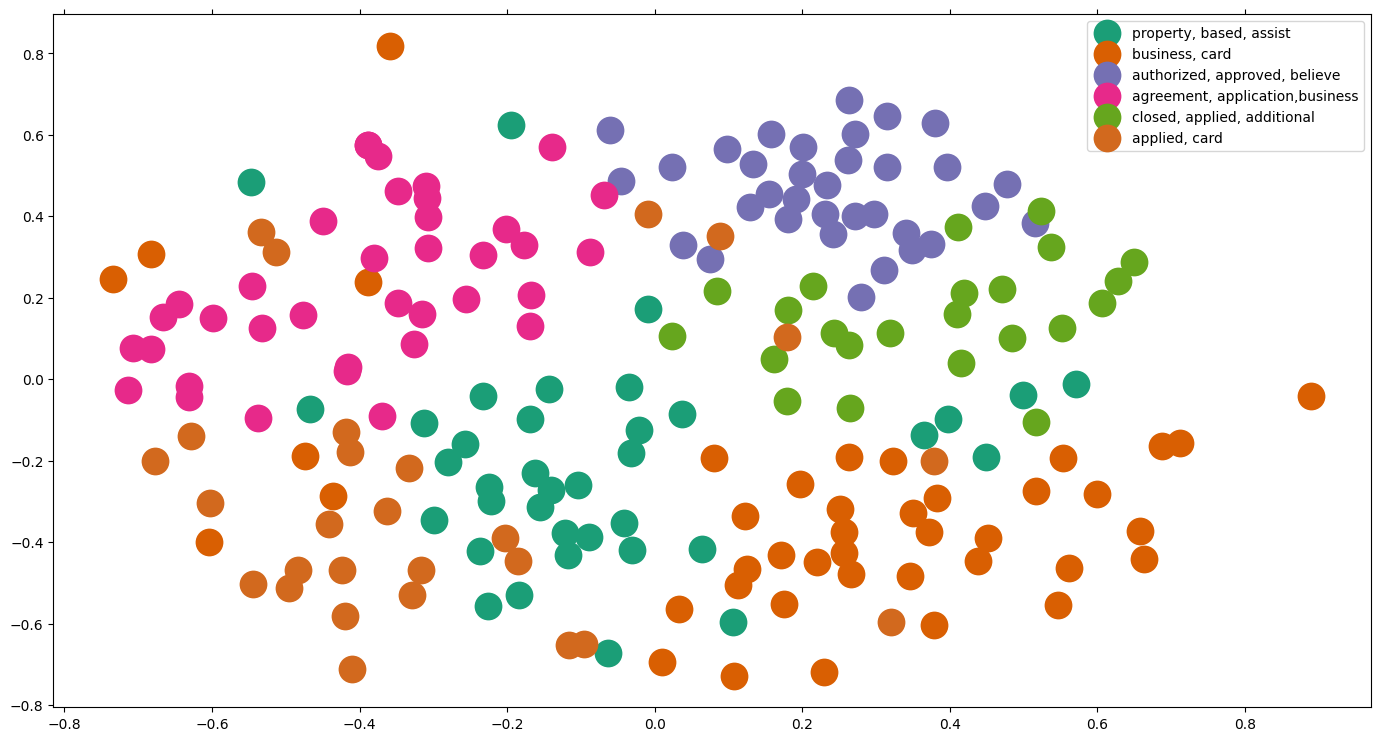

In [18]:
#Similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed",random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
1: 'business, card',
2: 'authorized, approved, believe',
3: 'agreement, application,business',
4: 'closed, applied, additional',
5: 'applied, card'}

# Finally plot it
%matplotlib inline

#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle="", ms=20, label=cluster_names[name], color=cluster_colors[name],mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
ax.legend(numpoints=1)
plt.show()